# To-Do
Avg. CV IKI by word type (WF and BF)  
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  

In [1]:
import numpy as np
import pandas as pd
import ast
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import variation
from scipy.stats import wilcoxon
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import typingmod as typ

# DATAFRAME SETUP AND FUNCTIONS
___

In [2]:
np.seterr(invalid='ignore') ## gets rid of runtime error about invalid division

ID_list = ['s20', 's175', 's178', 's180', 's181', 's182', 's183', 's189', 's190', 's198', 's207', 's209', 's210', 's212',
          's217', 's219', 's224']

##, 'p09', 'p10', 'p11'

In [84]:
## making one trial based dataframe using data from all participants
all_maindfs = glob.glob("subject_data/main_dfs/*.csv")
all_trials = (pd.concat((pd.read_csv(f) for f in all_maindfs))).reset_index(drop=True)
# print(all_trials)

## making dataframe of only rts from all trials
all_rts = typ.rt_columns(all_trials)

## adding ikis to main dataframe using all_rts
all_trials = pd.concat([all_trials, typ.iki(all_rts).iloc[:,1:7]], axis = 1)
all_trials = all_trials.rename(columns={0: 'iki_1', 1: 'iki_2', 2: 'iki_3', 3: 'iki_4', 4: 'iki_5', 5: 'iki_6'})
all_trials = all_trials.drop(columns=['Unnamed: 0'])

## making one trial based dataframe using data from all participants
all_bigramdfs = glob.glob("subject_data/bigram_dfs/*.csv")
all_bigrams = (pd.concat((pd.read_csv(f) for f in all_bigramdfs))).reset_index(drop=True)
all_bigrams['Bigram'] = all_bigrams['Bigram'].apply(lambda x: (x.replace("'", "")).replace(" ", ""))
all_bigrams = all_bigrams.rename(columns = {'Trial #': 'trial', 'bigram #': 'bigram_num', 'Bigram': 'bigram'})
all_bigrams = all_bigrams.drop(columns=['Unnamed: 0'])

## making filtered dataframes
corr_trials = (all_trials[all_trials.string == all_trials.resp_string]).reset_index(drop=True)
incorr_trials = (all_trials[all_trials.string != all_trials.resp_string]).reset_index(drop=True)

corr_trials_bybg = typ.correct_filter(all_bigrams) ## only correct trials
incorr_trials_bybg = typ.incorrect_filter(all_bigrams) ## only incorrect trials

corr_bgs = (all_bigrams[all_bigrams.bigram == all_bigrams.corr_bigram]).reset_index(drop=True)
incorr_bgs = (all_bigrams[all_bigrams.bigram != all_bigrams.corr_bigram]).reset_index(drop=True)

corr_rts = typ.rt_columns(corr_trials) ## only correct rts
incorr_rts = typ.rt_columns(incorr_trials) ## only incorrect rts

## making filtered dataframes by word frequency
highwf_df = all_trials[all_trials['string'].isin(typ.highwf)]
medwf_df = all_trials[all_trials['string'].isin(typ.medwf)]
lowwf_df = all_trials[all_trials['string'].isin(typ.lowwf)]
pseudo_df = all_trials[all_trials['string'].isin(typ.pseudo)]

## making filtered dataframes by bigram frequency
highbf_df = all_trials[all_trials['string'].isin(typ.highbf)]
medbf_df = all_trials[all_trials['string'].isin(typ.medbf)]
lowbf_df = all_trials[all_trials['string'].isin(typ.lowbf)]

## making dataframes with rts by word frequency type
highwf_rts = (typ.rt_columns(highwf_df)).reset_index(drop=True)
medwf_rts = (typ.rt_columns(medwf_df)).reset_index(drop=True)
lowwf_rts = (typ.rt_columns(lowwf_df)).reset_index(drop=True)
pseudo_rts = (typ.rt_columns(pseudo_df)).reset_index(drop=True)

## making dataframes with rts by bigram frequency type
highbf_rts = (typ.rt_columns(highbf_df)).reset_index(drop=True)
medbf_rts = (typ.rt_columns(medbf_df)).reset_index(drop=True)
lowbf_rts = (typ.rt_columns(lowbf_df)).reset_index(drop=True)

## making dataframe with only correct trials that have ikis within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.iloc[:, 24:28]: ## depends on position of iki columns
        avg_iki = sub_df[col].mean()
        sd_iki = sub_df[col].std()
        sub_df = sub_df.loc[(sub_df[col] < (avg_iki + 2*sd_iki)) & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])
    
## making dataframe with only correct bigrams that have ikis within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
## making dataframe with both correct and incorrect bigrams that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

In [4]:
all_bigrams.to_csv('all_bigrams.csv')
all_bigrams

,sID,Bigram #,trial,bigram_loc,bigram,corr_bigram,IKI,string,resp_string,rep #,bg_freq,bf_type,meanbf_type,wf_type
0,s209,0,0,0,th,th,0.063975,think,think,0,22288309.0,high,high,high
1,s209,1,0,1,hi,hi,0.111985,think,think,0,6198006.0,high,high,high
2,s209,2,0,2,in,in,0.167919,think,think,0,13597302.0,high,high,high
3,s209,3,0,3,nk,nk,0.232104,think,think,0,445067.0,high,high,high
4,s209,4,1,0,he,he,0.120036,heond,heond,0,21484684.0,high,high,pseudo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16395,s219,958,238,3,ka,ka,0.336047,pykka,pykka,9,60568.0,low,low,pseudo
16396,s219,959,239,0,zi,zi,0.264023,zibja,zibja,9,54565.0,low,low,pseudo
16397,s219,960,239,1,ib,ib,0.623901,zibja,zibja,9,493267.0,low,low,pseudo
16398,s219,961,239,2,bj,bj,0.336115,zibja,zibja,9,105433.0,low,low,pseudo


In [5]:
highwf_ikis = pd.concat([typ.iki(highwf_rts)[0], typ.iki(highwf_rts)[1], typ.iki(highwf_rts)[2], typ.iki(highwf_rts)[3]], axis=0, ignore_index=True)
medwf_ikis = pd.concat([typ.iki(medwf_rts)[0], typ.iki(medwf_rts)[1], typ.iki(medwf_rts)[2], typ.iki(medwf_rts)[3]], axis=0, ignore_index=True)
lowwf_ikis = pd.concat([typ.iki(lowwf_rts)[0], typ.iki(lowwf_rts)[1], typ.iki(lowwf_rts)[2], typ.iki(lowwf_rts)[3]], axis=0, ignore_index=True)
pseudo_ikis = pd.concat([typ.iki(pseudo_rts)[0], typ.iki(pseudo_rts)[1], typ.iki(pseudo_rts)[2], typ.iki(pseudo_rts)[3]], axis=0, ignore_index=True)

highbf_ikis = pd.concat([typ.iki(highbf_rts)[0], typ.iki(highbf_rts)[1], typ.iki(highbf_rts)[2], typ.iki(highbf_rts)[3]], axis=0, ignore_index=True)
medbf_ikis = pd.concat([typ.iki(medbf_rts)[0], typ.iki(medbf_rts)[1], typ.iki(medbf_rts)[2], typ.iki(medbf_rts)[3]], axis=0, ignore_index=True)
lowbf_ikis = pd.concat([typ.iki(lowbf_rts)[0], typ.iki(lowbf_rts)[1], typ.iki(lowbf_rts)[2], typ.iki(lowbf_rts)[3]], axis=0, ignore_index=True)

In [6]:
## defining function for finding CV IKI avg for each individual
def avgcv_bysub(word_type, DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        sub_avg = typ.avg_cv(word_type, sub_data)
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg CV 1', 'Avg CV 2', 'Avg CV 3', 'Avg CV 4'])
    return sub_avgs

## defining function for finding Avg IKI for each individual
def avgposiki_bysub(DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        ikis = typ.iki(sub_data)
        sub_avg = []
        ikis.iloc[:, 1:5].mean()
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI 1', 'Avg IKI 2', 'Avg IKI 3', 'Avg IKI 4'])
    return sub_avgs

def avgiki_bysub(DF):
    sub_avgs =[]
    for sub in ID_list:
        sub_data = pd.DataFrame()
        for index, data in DF.iterrows():
            if DF.loc[index, 'sID'] == sub:
                sub_data = sub_data.append(DF.loc[index], ignore_index=True)
        ikis = typ.iki(sub_data)
        iki_list = pd.concat([ikis[1], ikis[2], ikis[3], ikis[4]], ignore_index=True)
        sub_avg = []
        sub_avg.append(np.mean(iki_list))
        sub_avg.insert(0, sub)
        sub_avgs.append(sub_avg)
    sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI'])
    return sub_avgs

# def avgiki_bysub_bg(DF):
#     sub_avgs =[]
#     for sub in ID_list:
#         sub_data = pd.DataFrame()
#         for index, data in DF.iterrows():
#             if DF.loc[index, 'sID'] == sub:
#                 sub_data = sub_data.append(DF.loc[index], ignore_index=True)
#         sub_avg = []
#         sub_avg.append(np.mean(sub_data['IKI']))
#         sub_avg.insert(0, sub)
#         sub_avgs.append(sub_avg)
#     sub_avgs = pd.DataFrame(sub_avgs, columns = ['sID', 'Avg IKI'])
#     return sub_avgs

In [7]:
plt.rcParams['font.size'] = '30'

In [8]:
bg_freqs = pd.read_csv('bg_freqs.csv').drop(labels=['Unnamed: 0'], axis=1)
bg_freqs = bg_freqs.sort_values(by='Frequency', ascending=False, ignore_index=True)
# bg_freqs[0:60]

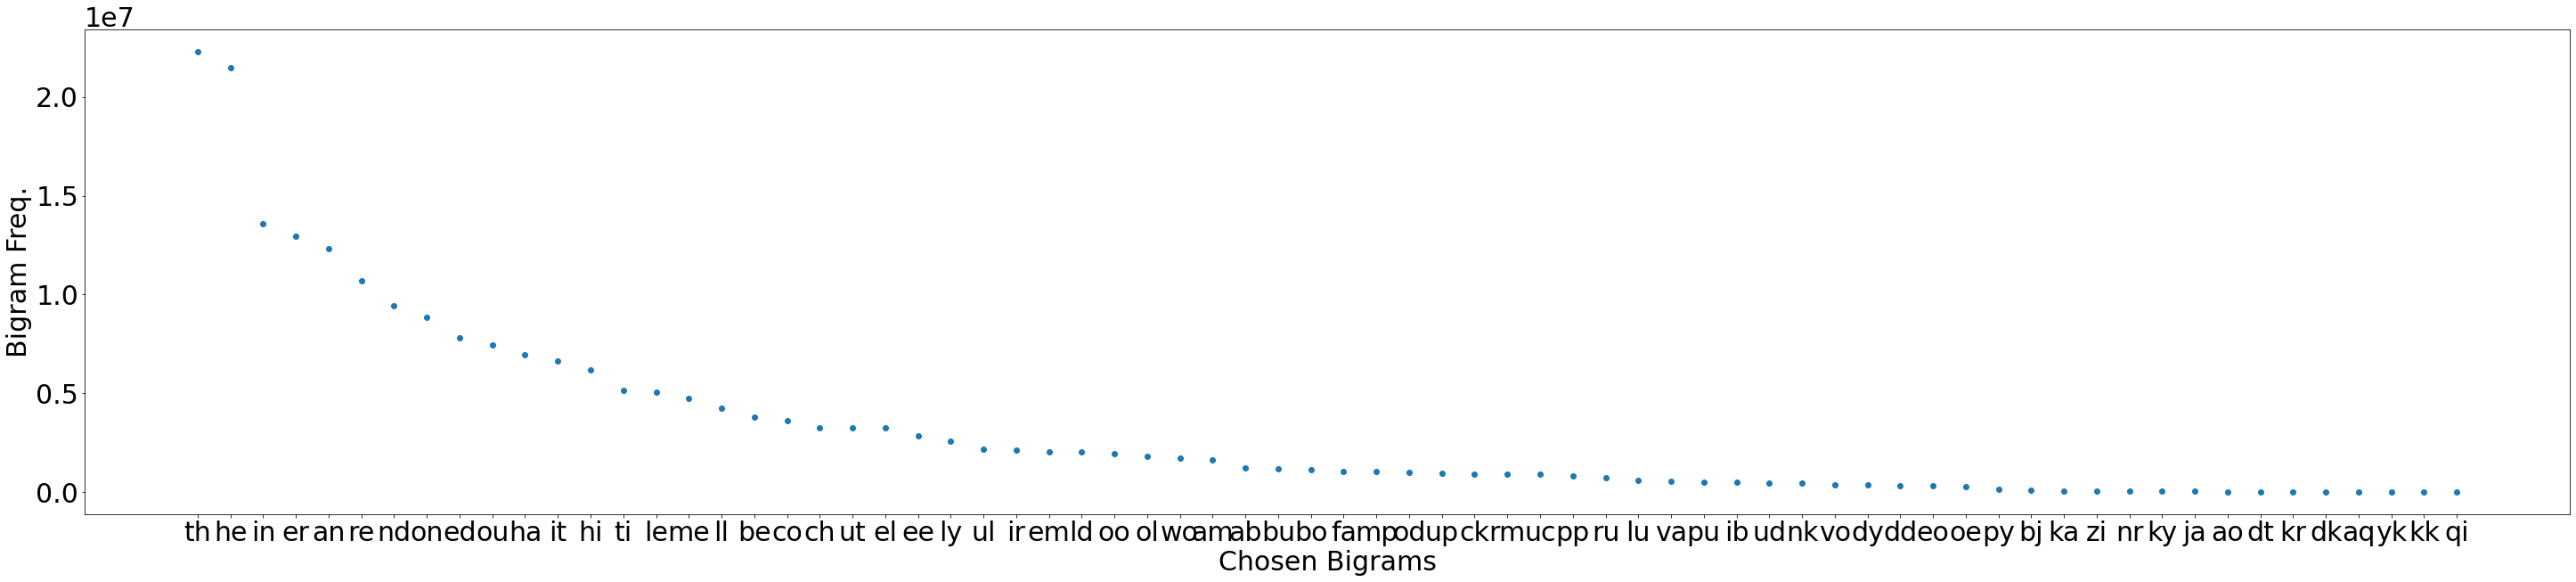

In [9]:
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(bg_freqs['Bigrams'], bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [10]:
high_bgs = bg_freqs.loc[0:15]
med_bgs = bg_freqs.loc[15:46]
low_bgs = bg_freqs.loc[46:69]

In [11]:
## defining function to organize bigram ikis
def bg_iki_sort(DF, sort_parameter): # DF is all_bgs or corr_trials_bybg, sort_parameter is relevant list of strings
    bg_ikis = []
    bg_strings = []
    for bg in bg_freqs['Bigrams']:
        ikis = [bg]
        strings = [bg]
        for index, data in DF.iterrows():
            if ((DF['bigram'][index]).replace("'", "")).replace(" ", "") == bg and DF['string'][index] in sort_parameter:
                ikis.append(DF['IKI'][index])
                strings.append(DF['string'][index])
        bg_ikis.append(ikis)
        bg_strings.append(strings)
            
    return pd.DataFrame(bg_ikis)
#     bg_strings = pd.DataFrame(bg_strings)

In [12]:
## THIS IS SUPER SLOW REWRITE
bg_ikis = []
bg_strings = []
for bg in bg_freqs['Bigrams']:
    ikis = [bg]
    strings = [bg]
    for index, data in corr_trials_bybg.iterrows():
        if corr_trials_bybg['bigram'][index] == bg:
            ikis.append(corr_trials_bybg['IKI'][index])
            strings.append(corr_trials_bybg['string'][index])
    bg_ikis.append(ikis)
    bg_strings.append(strings)
    
            
bg_ikis = pd.DataFrame(bg_ikis)
bg_strings = pd.DataFrame(bg_strings)

bg_xvals = []
for n in range(0,70):
    bg_xvals.append([n]*577)
    
bg_xvals = pd.DataFrame(bg_xvals)

In [13]:
bg_freqs

,Bigrams,Frequency
0,th,22288309
1,he,21484684
2,in,13597302
3,er,12934901
4,an,12315713
...,...,...
65,dk,5347
66,aq,4924
67,yk,4767
68,kk,1820


In [74]:
bg_stats = []
for index, data in bg_ikis.iterrows():
    bg_stats.append([bg_ikis.iloc[index, 0], 
                     bg_ikis.iloc[index, 1:577].mean(), 
                     np.std(bg_ikis.iloc[index, 1:577]), 
                     variation((bg_ikis.iloc[index, 1:577].tolist()), nan_policy='omit')])
    
bg_stats = pd.DataFrame(bg_stats, columns=['Bigram', 'Mean', 'STD', 'CV'])
bg_stats = pd.concat([bg_stats, bg_freqs['Frequency']], axis = 1)

name_list = ['high', 'med', 'low', 'pseudo']
for index, bg_type in enumerate(typ.bg_types):
    by_bf = bg_stats[bg_stats.Bigram.isin(bg_type)]
    rows = by_bf.index
    bg_stats.loc[rows, 'bf_type'] = name_list[index]
    
bg_stats.to_csv('bg_stats.csv')

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(bg_stats)

   Bigram      Mean       STD        CV  Frequency bf_type
0      th  0.104583  0.047412  0.453342   22288309    high
1      he  0.123847  0.064345  0.519550   21484684    high
2      in  0.159219  0.058762  0.369063   13597302    high
3      er  0.119146  0.049242  0.413294   12934901    high
4      an  0.175748  0.127877  0.727616   12315713     med
5      re  0.135506  0.138370  1.021139   10687711     med
6      nd  0.146485  0.083838  0.572334    9414961    high
7      on  0.193413  0.073694  0.381018    8830487    high
8      ed  0.199383  0.132022  0.662154    7805967     med
9      ou  0.141003  0.070413  0.499373    7425307     med
10     ha  0.148030  0.094051  0.635352    6967591     med
11     it  0.150635  0.064198  0.426184    6637233    high
12     hi  0.154737  0.051088  0.330160    6198006    high
13     ti  0.153627  0.122388  0.796658    5135552    high
14     le  0.113470  0.071405  0.629283    5038239     med
15     me  0.113959  0.073122  0.641648    4724108    hi

In [15]:
def bgplot_bystr():
    for string in typ.all_strings:
        s = bg_strings[bg_strings.isin([string])].stack()
        L = s.index.tolist()
        xvals = []
        ikis = []
        for i in L:
            xvals.append(bg_xvals.iloc[i])
            ikis.append(bg_ikis.iloc[i])
    rbg = np.random.rand(3,).reshape(1,-1)
    plt.scatter(xvals, ikis, c=rbg)

In [16]:
bg_strings

,0,1,2,3,4,5,6,7,8,9,...,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121
0,th,think,edthe,there,think,theme,theme,edthe,there,tithe,...,None,None,None,None,None,None,None,None,None,None
1,he,heond,edthe,there,theme,cheer,theme,edthe,there,tithe,...,there,tithe,cheer,there,therm,edthe,tithe,edthe,cheer,theme
2,in,think,think,think,think,think,think,think,think,think,...,None,None,None,None,None,None,None,None,None,None
3,er,there,cheer,there,there,therm,therm,therm,cheer,cheer,...,None,None,None,None,None,None,None,None,None,None
4,an,vanru,vanru,vanru,vanru,vanru,vanru,vanru,vanru,vanru,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,dk,vodka,vodka,vodka,vodka,vodka,vodka,vodka,vodka,vodka,...,None,None,None,None,None,None,None,None,None,None
66,aq,faqir,faqir,faqir,faqir,faqir,faqir,faqir,faqir,faqir,...,None,None,None,None,None,None,None,None,None,None
67,yk,pykka,pykka,pykka,pykka,pykka,pykka,pykka,pykka,pykka,...,None,None,None,None,None,None,None,None,None,None
68,kk,pykka,pykka,pykka,pykka,pykka,pykka,pykka,pykka,pykka,...,None,None,None,None,None,None,None,None,None,None


In [17]:
# ## broken, need to fix

# ## scatter of iki values by bigram and word(color)
# plt.figure(figsize=(50, 30))

# for string in typ.all_strings:
#     s = bg_strings[bg_strings.isin([string])].stack()
#     L = s.index.tolist()
#     print(L)
#     xvals = []
#     ikis = []
#     for i in L:
#         xvals.append(bg_xvals.iloc[i])
#         ikis.append(bg_ikis.iloc[i])
#     rbg = np.random.rand(3,).reshape(1,-1)
#     plt.scatter(xvals, ikis, c=rbg)

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# # plt.legend(loc= "best")
# plt.ylim([0, 1])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [18]:
# ## broken, need to fix

# ## scatter of iki values by bigram and word
# plt.figure(figsize=(50, 20))

# string = 'there'

# s = bg_strings[bg_strings.isin([string])].stack()
# L = s.index.tolist()
# xvals = []
# ikis = []
# for i in L:
#     xvals.append(bg_xvals.iloc[i])
#     ikis.append(bg_ikis.iloc[i])
# rbg = np.random.rand(3,).reshape(1,-1)
# plt.scatter(xvals, ikis, c=rbg)

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# # plt.legend(loc= "best")
# plt.ylim([0, 0.5])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [19]:
# ## broken, need to fix

# ## scatter of iki values by bigram and word
# plt.figure(figsize=(50, 20))

# string = 'tithe'

# s = bg_strings[bg_strings.isin([string])].stack()
# L = s.index.tolist()
# xvals = []
# ikis = []
# for i in L:
#     xvals.append(bg_xvals.iloc[i])
#     ikis.append(bg_ikis.iloc[i])
# rbg = np.random.rand(3,).reshape(1,-1)
# plt.scatter(xvals, ikis, c=rbg)

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_freqs['Bigrams'])
# # plt.legend(loc= "best")
# plt.ylim([0, 1])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [20]:
## defining functions that calculate individual IKI means and CVs for a particular bigram in a defined string
##### these need to be edited to include changable dataframe like the other functions

def indiv_means_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings

def indiv_means(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg IKI'})
    # means.columns = ['Avg IKI']
    return means

def indiv_avgcvs(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg CV IKI'})
    # avg_cvs.columns = ['Avg CV IKI']
    return avg_cvs

def indiv_avgsds(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg SD IKI'})
    # avg_sds.columns = ['Avg SD IKI']
    return avg_sds

def indiv_error(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    else:
        print('please write "string" or "bigram"for str_or_bg variable')
    errs = pd.DataFrame(DF.groupby(['sID']).size()).reset_index().rename(columns = {0:'Total Error'})
    for ID in ID_list:
        if ID not in list(errs['sID']):
            no_err_ID = {'sID': ID, 'Total Error': 0}
            errs = errs.append(no_err_ID, ignore_index = True).sort_values('sID')
    return errs

In [21]:
all_bigrams

,sID,Bigram #,trial,bigram_loc,bigram,corr_bigram,IKI,string,resp_string,rep #,bg_freq,bf_type,meanbf_type,wf_type
0,s209,0,0,0,th,th,0.063975,think,think,0,22288309.0,high,high,high
1,s209,1,0,1,hi,hi,0.111985,think,think,0,6198006.0,high,high,high
2,s209,2,0,2,in,in,0.167919,think,think,0,13597302.0,high,high,high
3,s209,3,0,3,nk,nk,0.232104,think,think,0,445067.0,high,high,high
4,s209,4,1,0,he,he,0.120036,heond,heond,0,21484684.0,high,high,pseudo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16395,s219,958,238,3,ka,ka,0.336047,pykka,pykka,9,60568.0,low,low,pseudo
16396,s219,959,239,0,zi,zi,0.264023,zibja,zibja,9,54565.0,low,low,pseudo
16397,s219,960,239,1,ib,ib,0.623901,zibja,zibja,9,493267.0,low,low,pseudo
16398,s219,961,239,2,bj,bj,0.336115,zibja,zibja,9,105433.0,low,low,pseudo


In [22]:
# indiv_error(incorr_bgs, 'string', typ.medwf)
indiv_error(incorr_bgs, 'bigram', typ.highbf_bgs)
indiv_error(incorr_bgs, 'bigram', typ.medbf_bgs)
indiv_error(incorr_bgs, 'bigram', typ.lowbf_bgs)
# incorr_trials

,sID,Total Error
0,s175,12
1,s178,2
2,s180,5
3,s181,3
4,s182,6
5,s183,13
6,s189,0
7,s190,6
16,s198,0
8,s20,8


In [23]:
# indiv_error_bybg('there', 'th')
# # indiv_cvs_bybg('there', 'th')
# incorr_trials_bybg[incorr_trials_bybg['string'] == 'there']

In [24]:
# def indiv_means_strtype(str_type):
#     means = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.string.isin(str_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         means = means.append({'ID':sID, 'Words/Bigrams Used':str_type, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
#     return means

# def indiv_cvs_strtype(str_type):
#     cvs = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.string.isin(str_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         cvs = cvs.append({'ID':sID, 'Words/Bigrams Used':str_type, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
#     return cvs

# def indiv_means_bgtype(bg_type):
#     means = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.bigram.isin(bg_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         means = means.append({'ID':sID, 'Words/Bigrams Used':bg_type, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
#     return means

# def indiv_cvs_bgtype(bg_type):
#     cvs = pd.DataFrame()
#     DF = tight_bgs[tight_bgs.bigram.isin(bg_type)]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         cvs = cvs.append({'ID':sID, 'Words/Bigrams Used':bg_type, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
#     return cvs

# STATS
___

In [25]:
ages = [22 ,25, 20, 19, 25, 25, 26, 19, 19, 18, 25, 19, 22, 21, 19]
print(stat.mean(ages))
print(stat.stdev(ages))

21.6
2.8735244660769563


In [26]:
## anova for means (by bg freq)
high_iki = indiv_means(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])
low_iki['bf_type'] = 'low'

ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
iki_anova = AnovaRM(data=ikis, depvar='Avg IKI', subject='sID', within=['bf_type']).fit()
print(iki_anova)
print(iki_anova.anova_table["Pr > F"][0])

iki_tukey = pairwise_tukeyhsd(endog=ikis['Avg IKI'],
                          groups=ikis['bf_type'],
                          alpha=0.05)
print(iki_tukey)

                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
bf_type 89.0386 2.0000 32.0000 0.0000

8.401153243752956e-14
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  high    low   0.0564  0.001  0.0297 0.0832   True
  high    med   0.0267 0.0502    -0.0 0.0534  False
   low    med  -0.0297 0.0261 -0.0565 -0.003   True
---------------------------------------------------


In [27]:
## anova for cvs (by bg freq)
high_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])
high_cv['bf_type'] = 'high'
med_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])
med_cv['bf_type'] = 'med'
low_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])
low_cv['bf_type'] = 'low'

cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
cv_anova = AnovaRM(data=cvs, depvar='Avg CV IKI', subject='sID', within=['bf_type']).fit()
print(cv_anova)

cv_tukey = pairwise_tukeyhsd(endog=cvs['Avg CV IKI'],
                          groups=cvs['bf_type'],
                          alpha=0.05)
print(cv_tukey)

                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
bf_type  6.2413 2.0000 32.0000 0.0051

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  high    low  -0.0187 0.5736 -0.0637  0.0263  False
  high    med  -0.0522 0.0197 -0.0972 -0.0071   True
   low    med  -0.0335 0.1814 -0.0785  0.0116  False
----------------------------------------------------


In [28]:
## anova for sds (by bg freq)
high_sd = indiv_avgsds(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
sd_anova = AnovaRM(data=sds, depvar='Avg SD IKI', subject='sID', within=['bf_type']).fit()
print(sd_anova)

sd_tukey = pairwise_tukeyhsd(endog=sds['Avg SD IKI'],
                          groups=sds['bf_type'],
                          alpha=0.05)
print(sd_tukey)

                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
bf_type  6.6324 2.0000 32.0000 0.0039

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  high    low   0.0135 0.0874 -0.0016  0.0286  False
  high    med  -0.0035 0.8276 -0.0186  0.0116  False
   low    med   -0.017 0.0239 -0.0321 -0.0019   True
----------------------------------------------------


In [29]:
## anova for error rates (by bg freq)
high_err = indiv_error(incorr_bgs, 'bigram', high_bgs['Bigrams'])
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_bgs, 'bigram', med_bgs['Bigrams'])
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_bgs, 'bigram', low_bgs['Bigrams'])
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)
err_anova = AnovaRM(data=errs, depvar='Total Error', subject='sID', within=['bf_type']).fit()
print(sd_anova)

err_tukey = pairwise_tukeyhsd(endog=errs['Total Error'],
                          groups=errs['bf_type'],
                          alpha=0.05)
print(err_tukey)

                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
bf_type  6.6324 2.0000 32.0000 0.0039

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  high    low      0.0    0.9 -4.2588 4.2588  False
  high    med   1.2941 0.7265 -2.9646 5.5529  False
   low    med   1.2941 0.7265 -2.9646 5.5529  False
---------------------------------------------------


In [30]:
## anova for error rates (by avg bg freq)
high_err = indiv_error(incorr_trials, 'string', typ.highbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_trials, 'string', typ.medbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_trials, 'string', typ.lowbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)
err_anova = AnovaRM(data=errs, depvar='Total Error', subject='sID', within=['bf_type']).fit()
print(sd_anova)

err_tukey = pairwise_tukeyhsd(endog=errs['Total Error'],
                          groups=errs['bf_type'],
                          alpha=0.05)
print(err_tukey)

                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
bf_type  6.6324 2.0000 32.0000 0.0039

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  high    low   1.6471 0.5033 -1.8862 5.1803  False
  high    med   1.1765 0.6865 -2.3568 4.7097  False
   low    med  -0.4706    0.9 -4.0038 3.0626  False
---------------------------------------------------


In [31]:
## running signed rank test
# wilcoxon()

iki_ranks = (indiv_means(tight_bgs, 'bigram', high_bgs['Bigrams']).sort_values(by = 'Avg IKI', ignore_index = True)) ## ranked by ascending mean IKI
iki_ranks['rank'] = iki_ranks.index
iki_ranks = iki_ranks.sort_values(by = 'sID', ignore_index=True)

cv_ranks = (indiv_avgcvs(tight_bgs, 'bigram', high_bgs['Bigrams']).sort_values(by = 'Avg CV IKI', ignore_index = True)) ## ranked by ascending mean CV IKI
cv_ranks['rank'] = cv_ranks.index
cv_ranks = cv_ranks.sort_values(by = 'sID', ignore_index=True)

rank_diff = iki_ranks['rank'] - cv_ranks['rank']
rank_diff

wilcoxon(rank_diff)

# ranksums(indiv_means(tight_bgs, 'bigram', high_bgs['Bigrams'])['Avg IKI'], 
#          indiv_avgcvs(tight_bgs, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'])

# ranksums(indiv_means(all_bigrams, 'bigram', high_bgs['Bigrams'])['Avg IKI'],
#          indiv_avgcvs(all_bigrams, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'])

WilcoxonResult(statistic=76.0, pvalue=1.0)

In [32]:
## making dataframes for CV values
indiv_means(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])

,sID,Avg IKI
0,s175,0.165150
1,s178,0.140335
2,s180,0.104463
3,s181,0.091451
4,s182,0.128974
5,s183,0.139171
6,s189,0.141276
7,s190,0.145054
8,s198,0.139238
9,s20,0.147844


In [95]:
skew_df = pd.DataFrame()
for index, ID in enumerate(ID_list):
    skew_df.loc[index, 'sID'] = ID
    skew_df.loc[index, 'skew'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].skew()
    skew_df.loc[index, 'mean IKI'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].mean()
    
skew_df.to_csv('skew_df.csv')
skew_df

,sID,skew,mean IKI
0,s20,3.202121,0.197018
1,s175,2.812225,0.191252
2,s178,9.766887,0.155502
3,s180,3.704217,0.132674
4,s181,4.930082,0.116986
5,s182,2.506407,0.169157
6,s183,4.123232,0.160179
7,s189,3.283803,0.173022
8,s190,2.493626,0.161795
9,s198,3.385264,0.160854


# GRAPHS
___

## Mean IKI GRAPHS
___

In [33]:
# plt.style.available
# plt.style.use('default')
plt.get_cmap('tab20')

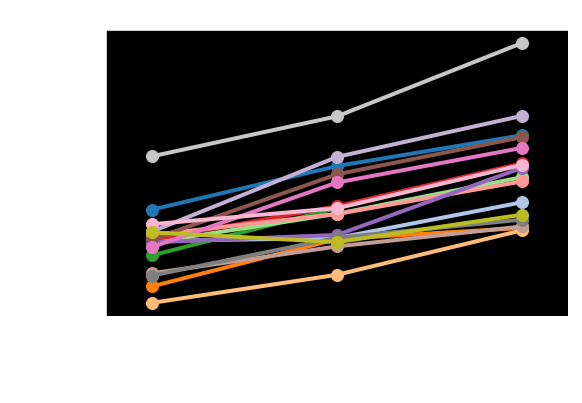

In [34]:
## individual IKI means by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

### Creates unique range of colors dependent on number of lines plotted -- useful if you plot more than 20 participants in one graph
## Current color map has 20 unique colors
# color = cm.rainbow(np.linspace(0, 1, len(ID_list)))
# for i, c in zip(range(len(ID_list)), color):
#     plt.plot(x, [l[i] for l in D], '.-', linewidth = 2.5, ms = 20, c = c)

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

### Adds mean values on chart
# ax.plot(x, means, '_', linewidth = 10, ms = 50, color = 'magenta')

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

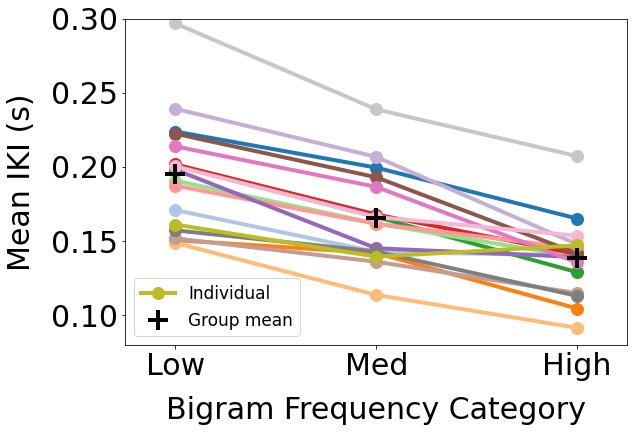

In [35]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    if index == len(ID_list)-1:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
    else:
        plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.3])
plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")
0
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

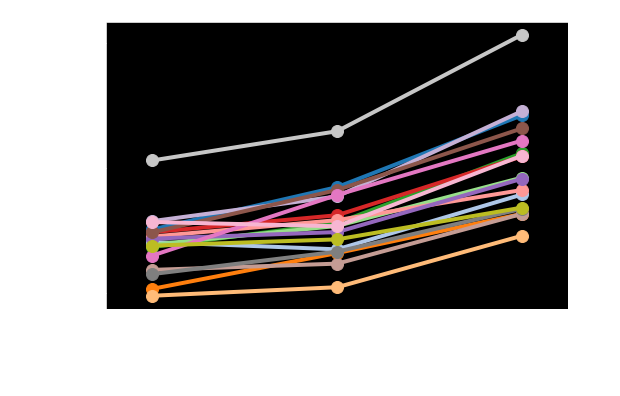

In [36]:
## individual IKI means by word BF category (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'string', typ.highbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.medbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.lowbf)['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, transparent = True)
plt.show()

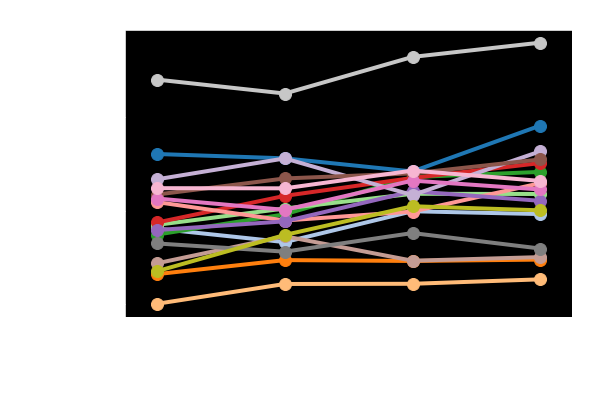

In [37]:
## individual IKI means by WF category (tight trials only -- correct and within 2 SD)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6, 8]
D = (indiv_means(tight_bgs, 'string', typ.highwf)['Avg IKI'], 
     indiv_means(tight_bgs, 'string', typ.medwf)['Avg IKI'], 
     indiv_means(tight_bgs, 'string', typ.lowwf)['Avg IKI'],
    indiv_means(tight_bgs, 'string', typ.pseudo)['Avg IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High', 'Med', 'Low', 'Pseudo'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

## CV GRAPHS
___

In [38]:
## making dataframe of cv values
cv_df = pd.concat(
    [indiv_avgcvs(all_bigrams, 'bigram', high_bgs['Bigrams']),
    indiv_avgcvs(all_bigrams, 'bigram', med_bgs['Bigrams']).rename(columns = {'Avg CV IKI': 'meanCV_med'})['meanCV_med'],
    indiv_avgcvs(all_bigrams, 'bigram', low_bgs['Bigrams']).rename(columns = {'Avg CV IKI': 'meanCV_low'})['meanCV_low']], 
    axis = 1)
cv_df = cv_df.rename(columns = {cv_df.columns[1]: 'meanCV_high'})
cv_df

,sID,meanCV_high,meanCV_med,meanCV_low
0,s175,0.298815,0.220436,0.326617
1,s178,0.668187,0.249186,0.291999
2,s180,0.351354,0.251469,0.295590
3,s181,0.297803,0.203571,0.239375
4,s182,0.277589,0.221562,0.312208
5,s183,0.435545,0.253497,0.276860
6,s189,0.214375,0.234193,0.258085
7,s190,0.246471,0.167100,0.243357
8,s198,0.272683,0.179630,0.242501
9,s20,0.507446,0.335923,0.355443


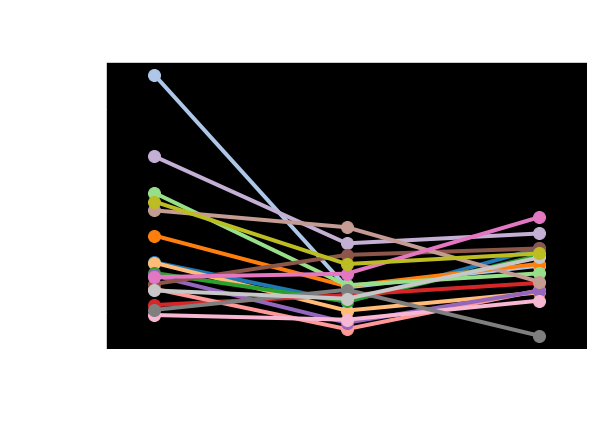

In [40]:
## bg_stats bigrams sorted by BF (all trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(all_bigrams, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', med_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', low_bgs['Bigrams'])['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

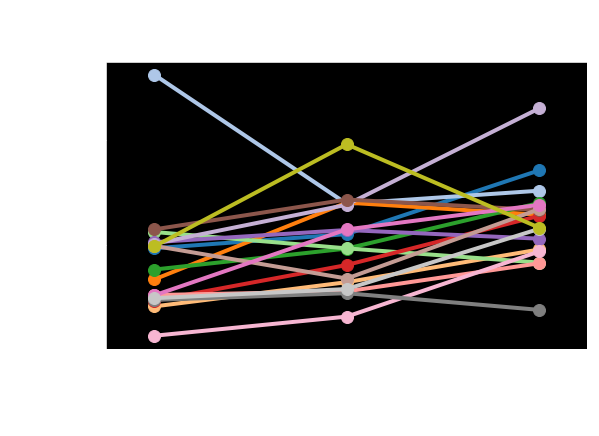

In [41]:
## using bigrams sorted by word BF category (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'string', typ.highbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.lowbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_cvikis_bybf.png', dpi=300, transparent = True)
plt.show()

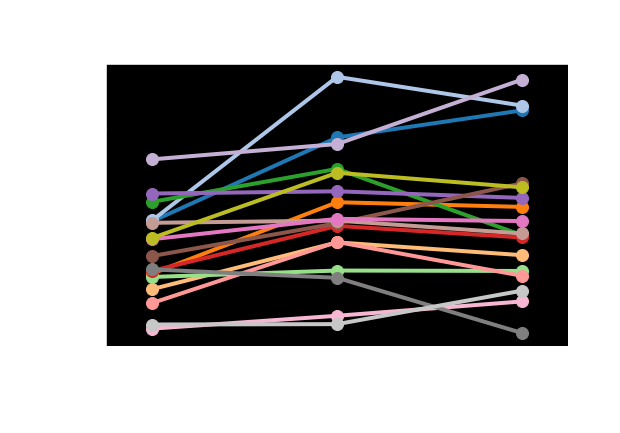

In [42]:
# individual avg CV IKIs by word BF category (currently using tight_bgs df)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(tight_bgs, 'string', typ.highbf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.lowbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

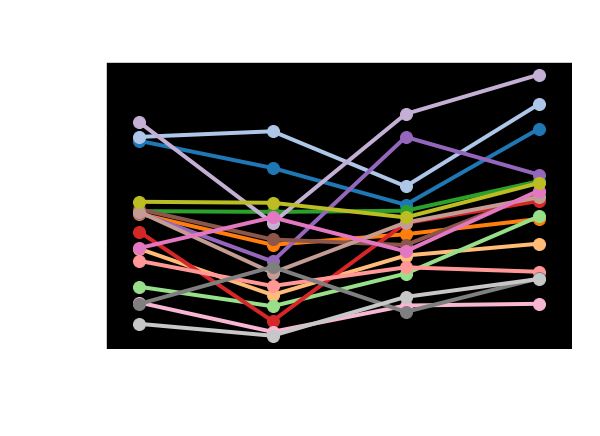

In [43]:
## individual avg CV IKI by WF category (can also change dataframe here)
x = [2, 4, 6, 8]
D = (indiv_avgcvs(tight_bgs, 'string', typ.highwf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.medwf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.lowwf)['Avg CV IKI'],
     indiv_avgcvs(tight_bgs, 'string', typ.pseudo)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High', 'Med', 'Low', 'Pseudo'))
plt.xlabel("Word Frequency Category", labelpad=15)

plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

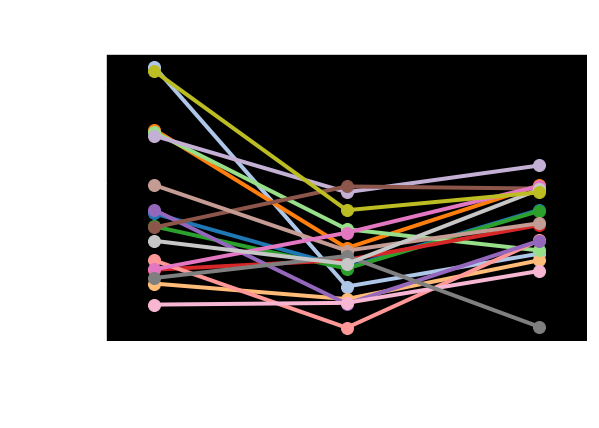

In [44]:
## using bigrams sorted by BF (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKI (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_cvikis_bybf.png', dpi=300, transparent = True)
plt.show()

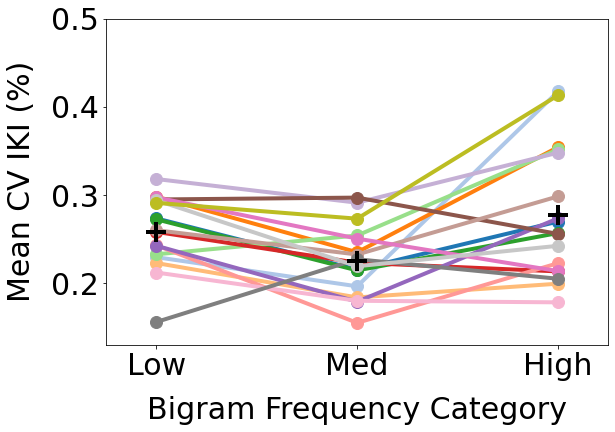

In [45]:
## using bigrams sorted by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean CV IKI (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## SD GRAPHS
___

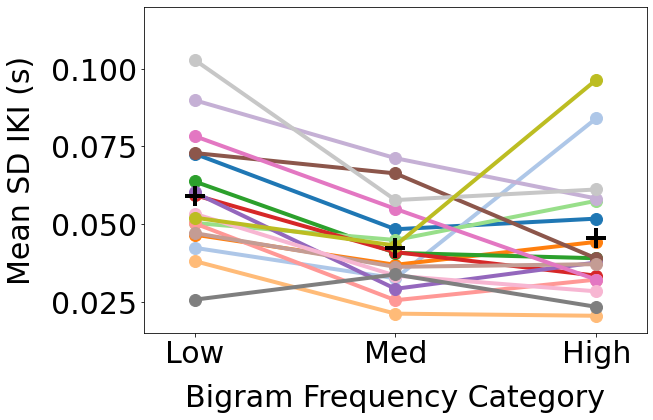

In [46]:
## individual average std by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.015, 0.12])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean SD IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

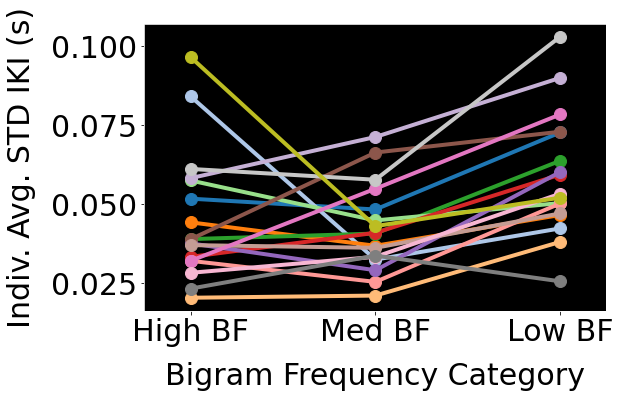

In [47]:
## individual average std by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'bigram', high_bgs['Bigrams'])['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'bigram', med_bgs['Bigrams'])['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'bigram', low_bgs['Bigrams'])['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, transparent = True)
plt.show()

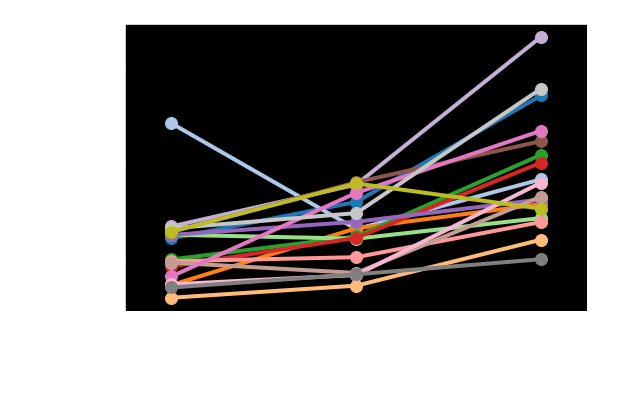

In [48]:
## individual average std by word BF category (only correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.highbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.lowbf)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

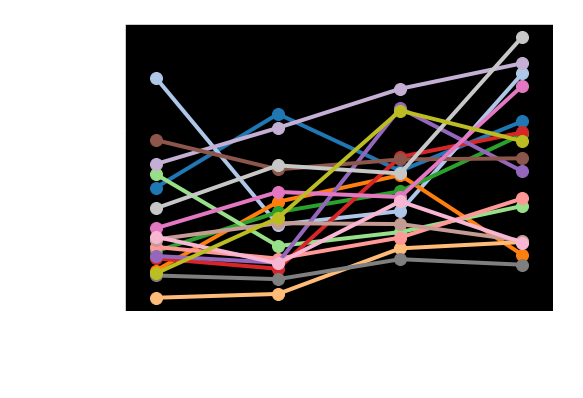

In [49]:
## individual average std by WF (correct trials only)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.highwf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.medwf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

cm = plt.get_cmap('tab20')
for index, data in enumerate(ID_list):
    plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High', 'Med', 'Low', 'Pseudo'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

## BG FREQ GRAPHS
___

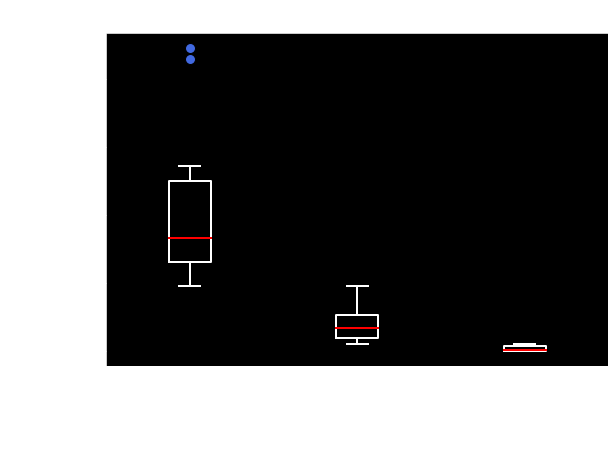

In [50]:
## plotting BF distribution of data set
x = [2, 4, 6]
D = (high_bgs['Frequency'], med_bgs['Frequency'], low_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'white')
whiskerprops = dict(linewidth=2, color = 'white')
capprops = dict(linewidth=2, color = 'white')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('wf.png', dpi=300)
plt.show()

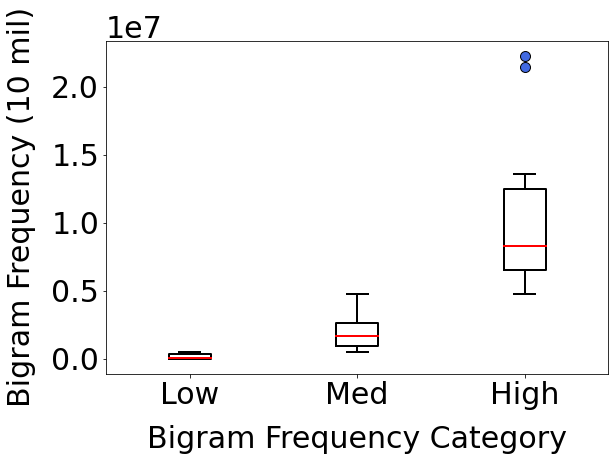

In [51]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'black')
whiskerprops = dict(linewidth=2, color = 'black')
capprops = dict(linewidth=2, color = 'black')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('wf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## ERROR GRAPHS
___

[17, 17, 17, 17]


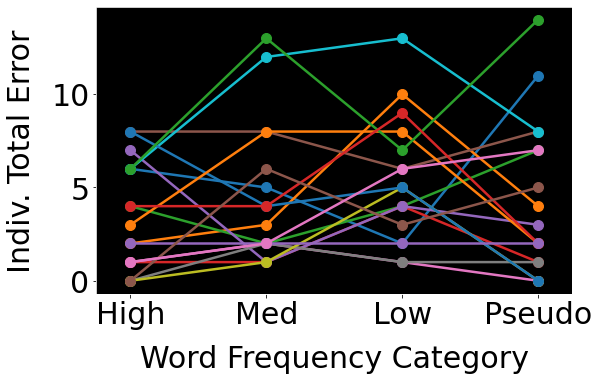

In [52]:
## plotting total trial error by WF
plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]

D = (indiv_error(incorr_trials, 'string', typ.highwf)['Total Error'], 
     indiv_error(incorr_trials, 'string', typ.medwf)['Total Error'],
     indiv_error(incorr_trials, 'string', typ.lowwf)['Total Error'],
     indiv_error(incorr_trials, 'string', typ.pseudo)['Total Error'])

fig, ax = plt.subplots(figsize=(9, 6))

print([len(x) for x in D])
ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High', 'Med', 'Low', 'Pseudo'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

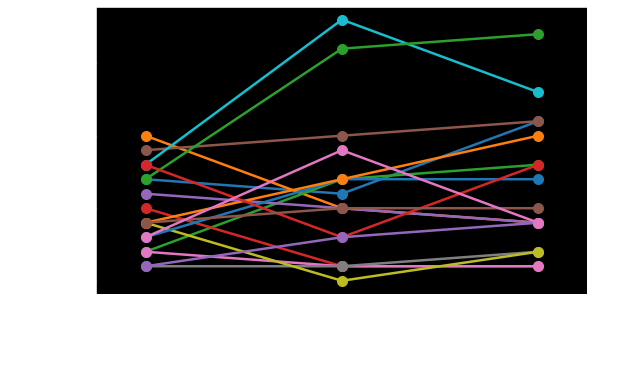

In [53]:
## plotting total trial error by word BF
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_trials, 'string', typ.highbf)['Total Error'], 
     indiv_error(incorr_trials, 'string', typ.medbf)['Total Error'],
     indiv_error(incorr_trials, 'string', typ.lowbf)['Total Error'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

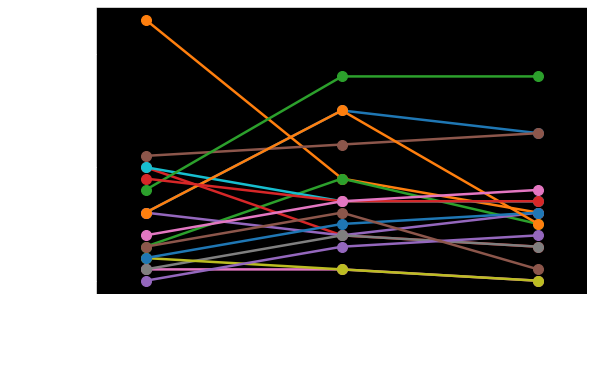

In [54]:
## plotting total trial error by bigram BF
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', high_bgs['Bigrams'])['Total Error'], 
     indiv_error(incorr_bgs, 'bigram', med_bgs['Bigrams'])['Total Error'],
     indiv_error(incorr_bgs, 'bigram', low_bgs['Bigrams'])['Total Error'])

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 2.5, ms = 20 )

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('High BF', 'Med BF', 'Low BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

## KIND OF USEFUL GRAPHS
____

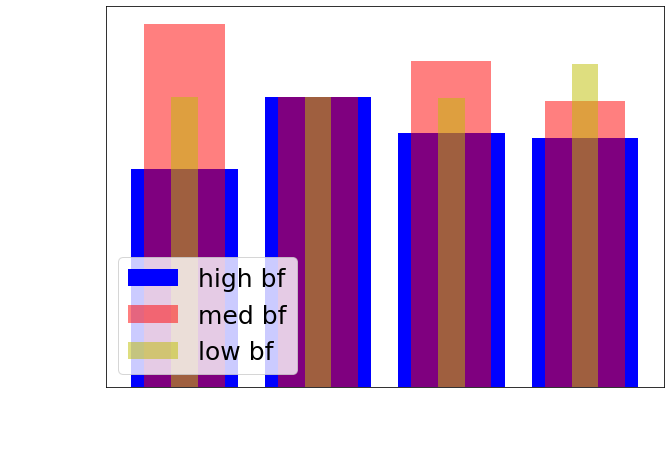

In [124]:
## plot showing distribution of bigram frequency types across each position in the string
locs = [0, 1, 2, 3]
type_list = ['high', 'med', 'low']

# for index, loc in enumerate(locs):
#     DF = all_bigrams[all_bigrams.bigram_loc == loc]
#     for typ in type_list:
#         print(loc)
#         print(typ)
#         print(DF[DF.bf_type == typ].count(axis ='rows'))
    
high = [1020, 1359, 1189, 1166]
med = [1700, 1360, 1530, 1341]
low = [1360, 1358, 1356, 1512]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high, width=width, 
        color='b', label='high bf')
plt.bar(indices, med, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks([0, 1, 2, 3])
plt.xlabel("IKI position")
plt.ylabel("Count")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

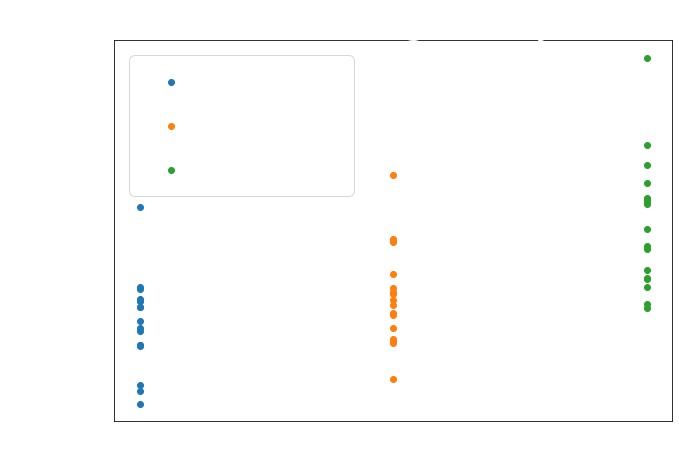

In [55]:
## Raster plot showing indiv. IKI averages by BF

plt.figure(figsize=(10, 7))
highbf_scatter = plt.scatter(([0] * len((avgiki_bysub(highbf_rts)).iloc[:, 1])), avgiki_bysub(highbf_rts).iloc[:, 1], label='High BF')
medbf_scatter = plt.scatter(([1] * len((avgiki_bysub(medbf_rts)).iloc[:, 1])), avgiki_bysub(medbf_rts).iloc[:, 1], label='Med BF')
lowbf_scatter = plt.scatter(([2] * len((avgiki_bysub(lowbf_rts)).iloc[:, 1])), avgiki_bysub(lowbf_rts).iloc[:, 1], label='Low BF')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by BF")
plt.legend(loc= "best")

plt.show()

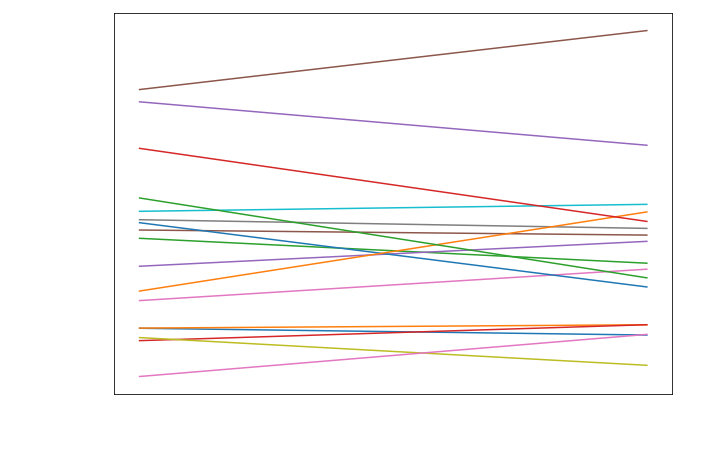

In [56]:
## plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

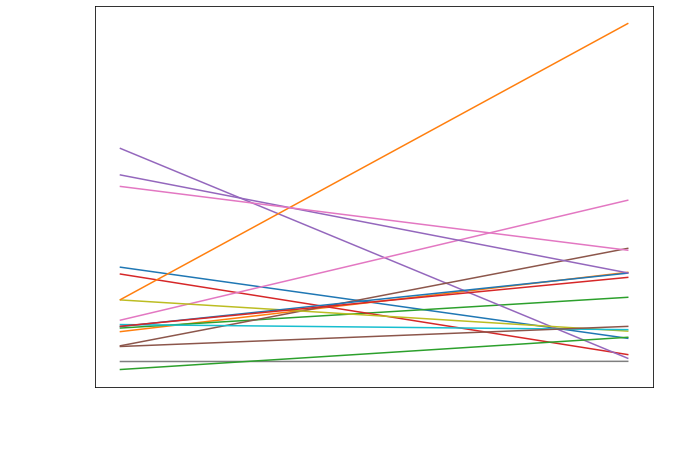

In [57]:
## plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

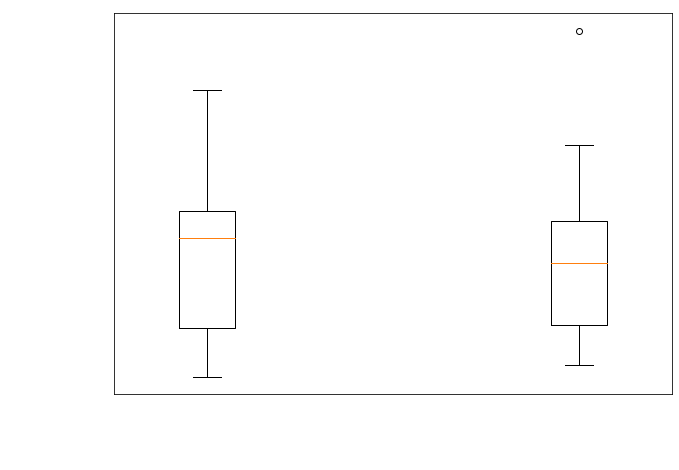

In [58]:
## box plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

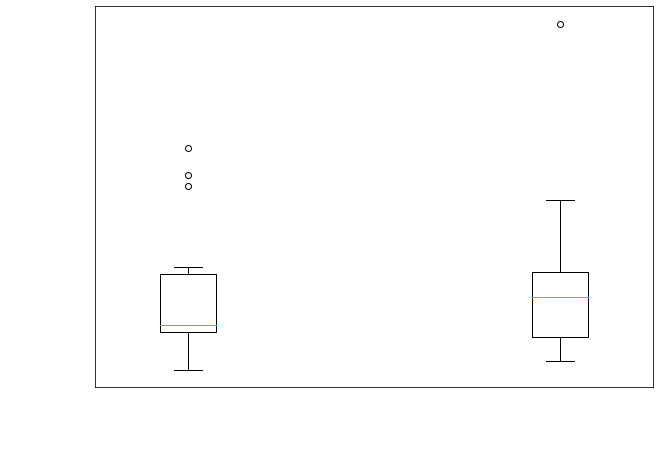

In [59]:
## box plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

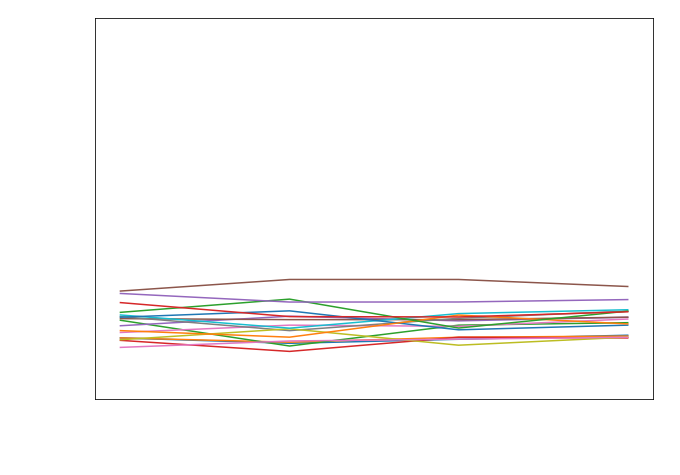

In [60]:
x = [2, 4, 6, 8]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('think', 'th')['mean'], 
     indiv_means_bybg('theme', 'th')['mean'], indiv_means_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

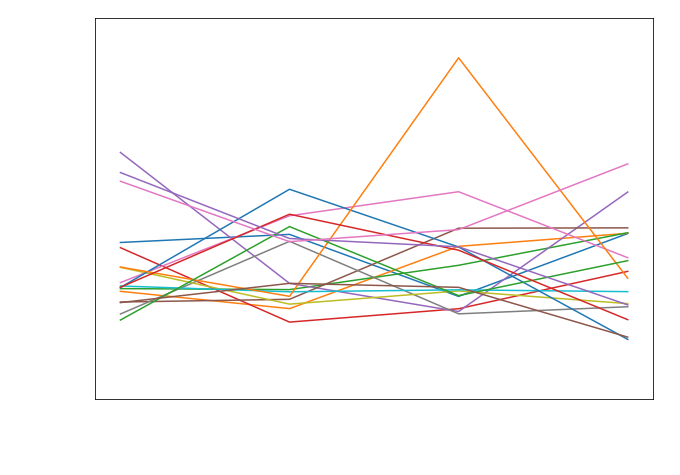

In [61]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

## Not Useful Graphs - Variables by Word and Word Type (WF and Avg. BF)
___

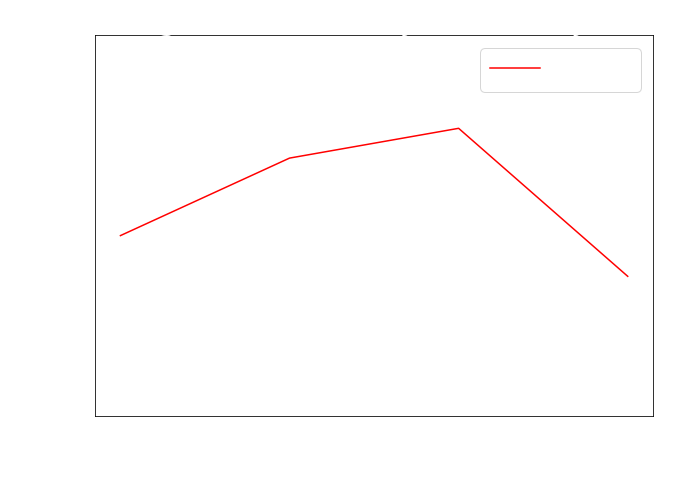

In [62]:
## creating dataframe from 'cv_byword' function that is easy to plot
cv_word = 'druze' # change this for which ever word you want to plot
cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

## plotting digraph latency variations by word (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

## Set general font size
plt.rcParams['font.size'] = '25'

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by Word")
plt.legend(loc="best")

plt.show()

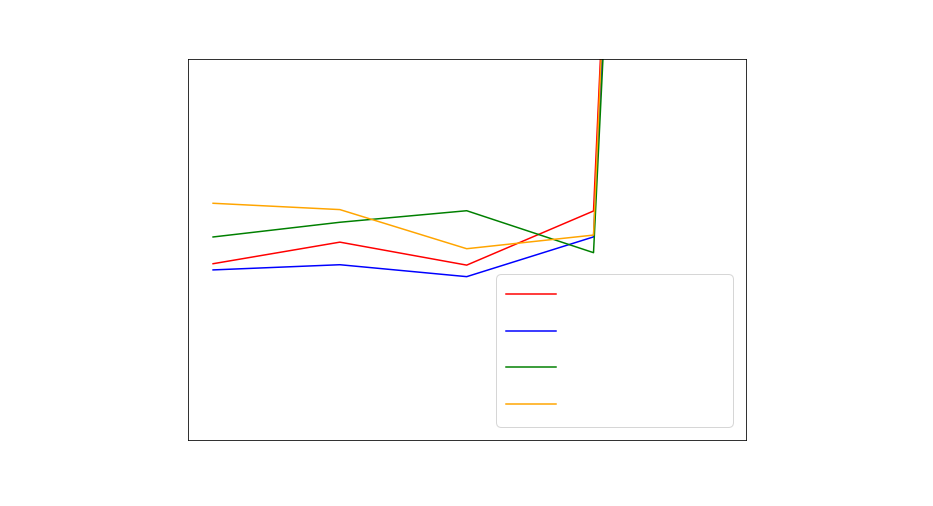

In [63]:
## plotting digraph latency variations by WF type (includes error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

## Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(25)

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Interval position in string")
plt.ylabel("Average CV")
plt.ylim([0, 1])
plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
plt.legend(loc="best")

# plt.savefig('ian_iki.png')

plt.show()

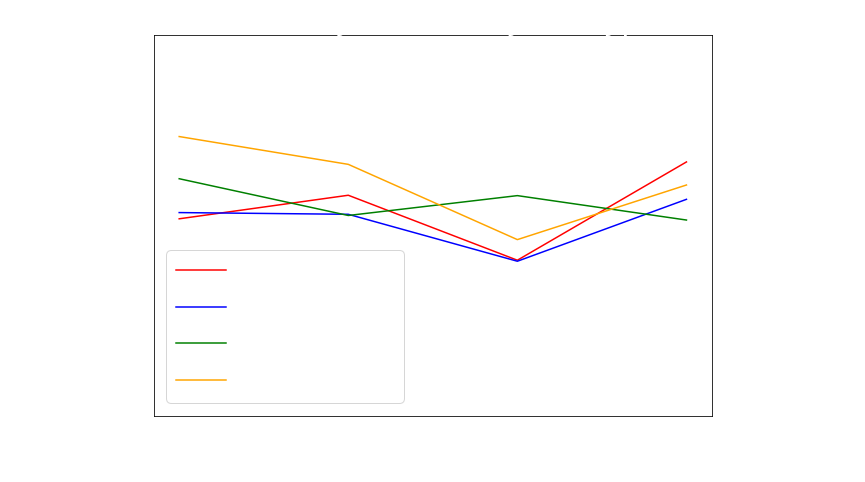

In [64]:
## plotting digraph latency variations by WF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by WF Type (w/out error)")
plt.legend(loc="best")

plt.show()

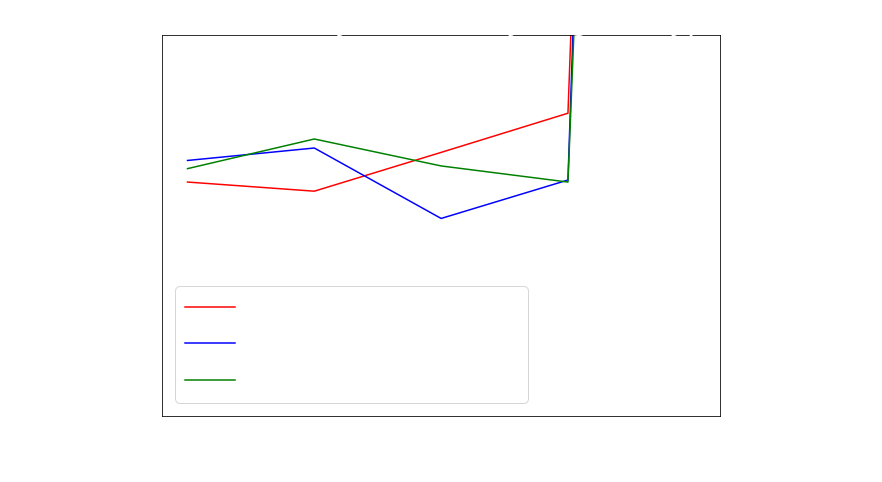

In [65]:
## plotting digraph latency variations by Avg. BF type (includes error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highbf_plot = plt.plot(typ.avg_cv(typ.highbf, all_rts), color='red', label='High bigram freq.')
medbf_plot = plt.plot(typ.avg_cv(typ.medbf, all_rts), color='blue', label='Medium bigram freq.')
lowbf_plot = plt.plot(typ.avg_cv(typ.lowbf, all_rts), color='green', label='Low bigram freq.')

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by Avg. BF Type (w/ error)")
plt.legend(loc="best")

plt.show()

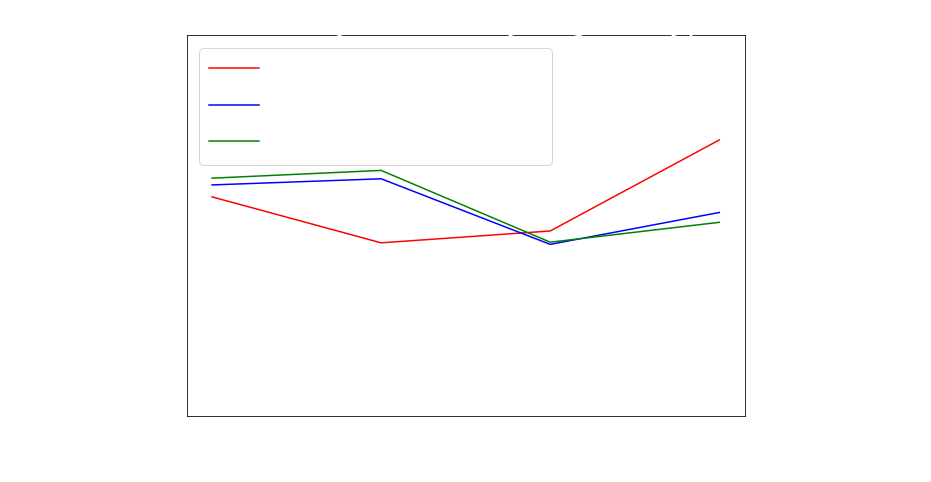

In [66]:
## plotting digraph latency variations by Avg. BF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highbf_plot = plt.plot(typ.avg_cv(typ.highbf, corr_rts), color='red', label='High bigram freq.')
medbf_plot = plt.plot(typ.avg_cv(typ.medbf, corr_rts), color='blue', label='Medium bigram freq.')
lowbf_plot = plt.plot(typ.avg_cv(typ.lowbf, corr_rts), color='green', label='Low bigram freq.')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.8])
plt.title("Average CV of Interkey Interval by Avg. BF Type (w/out error)")
plt.legend(loc="best")

plt.show()

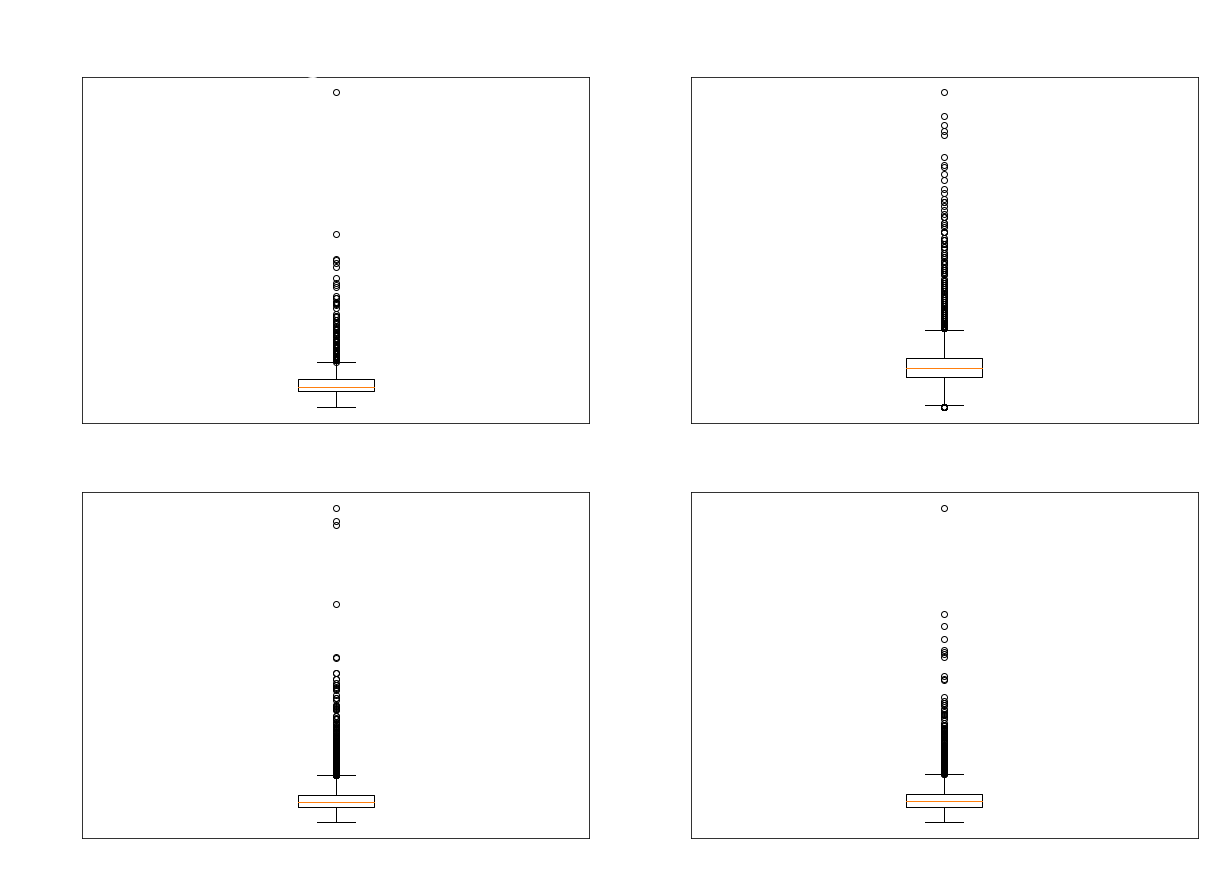

In [67]:
## 4-quadrant plot shoiwng IKI distribution by WF (for all words, not grouped)

figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('IKI Distribution by WF w/ error', y=0.95)

axs[0, 0].boxplot(highwf_ikis)
axs[0, 0].set_title("High WF")
# axs[0, 0].set_median(linewidth = 3)
# axs[0, 0].set_ylim([-0.01, 1])
axs[0, 1].boxplot(medwf_ikis)
axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1])
axs[1, 0].boxplot(lowwf_ikis)
axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1])
axs[1, 1].boxplot(pseudo_ikis)
axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1])

for ax in axs.flat:
    ax.set(ylabel='IKI (s)', xlabel='')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

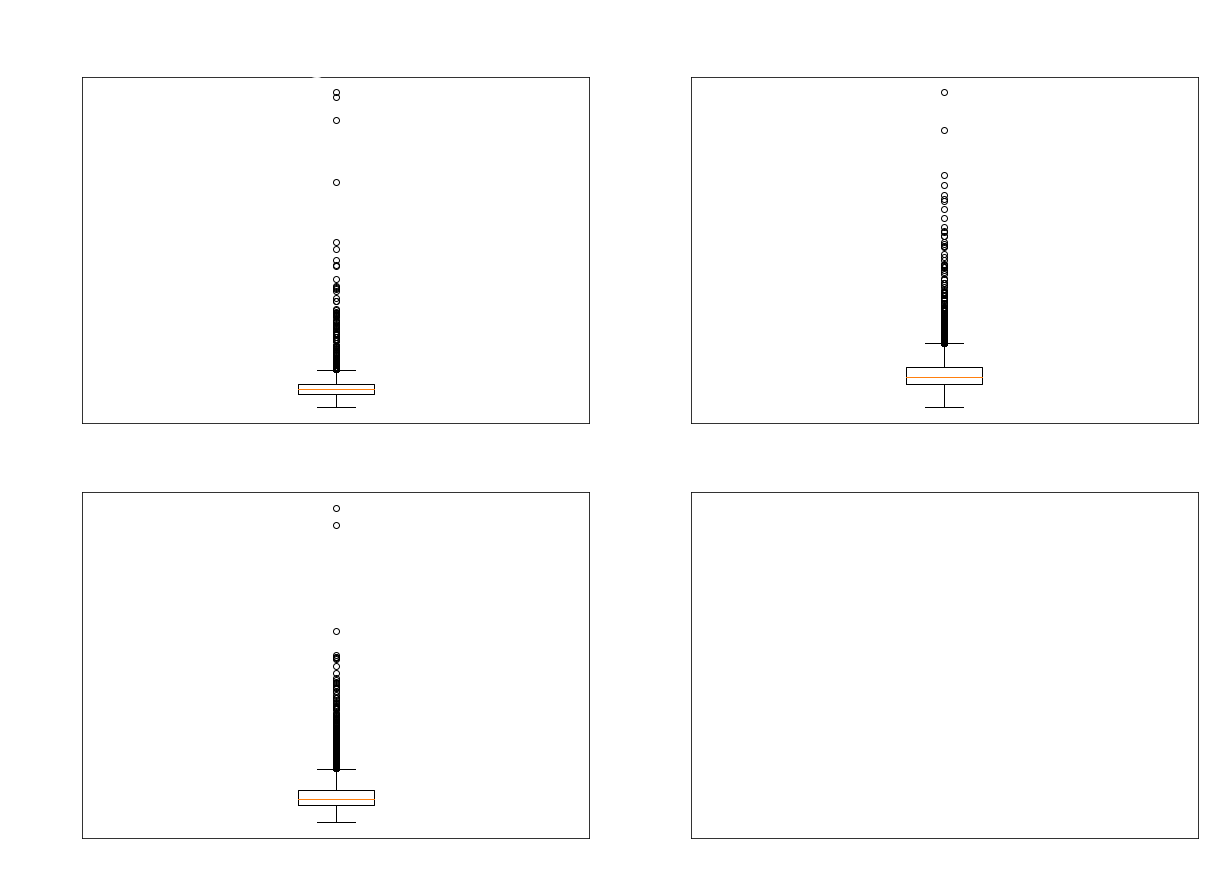

In [68]:
## 4-quadrant plot shoiwng IKI distribution by Avg. BF (for all words, not grouped)

figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('IKI Distribution by Avg. BF w/ error', y=0.95)

axs[0, 0].boxplot(highbf_ikis)
axs[0, 0].set_title("High BF")
# axs[0, 0].set_median(linewidth = 3)
# axs[0, 0].set_ylim([-0.01, 1])
axs[0, 1].boxplot(medbf_ikis)
axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1])
axs[1, 0].boxplot(lowbf_ikis)
axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1])

for ax in axs.flat:
    ax.set(ylabel='IKI (s)', xlabel='')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

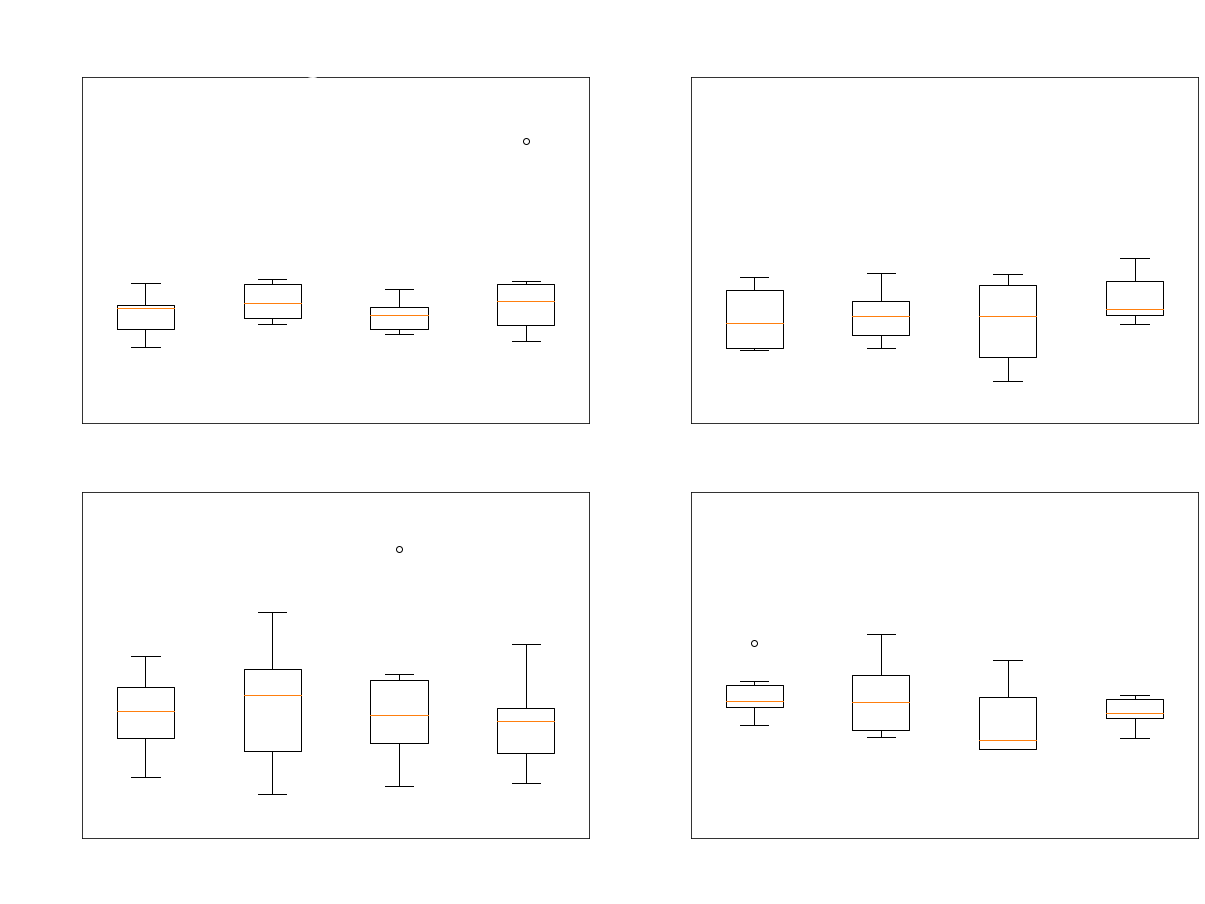

In [69]:
## 4-quadrant plot showing CV IKI distribution for IKI position in the string by WF (includes error, for all words not grouped)

figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
axs[0, 0].set_title("High WF")
axs[0, 0].set_ylim([-0.01, 1.5])
axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
axs[0, 1].set_title("Med WF")
axs[0, 1].set_ylim([-0.01, 1.5])
axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
axs[1, 0].set_title("Low WF")
axs[1, 0].set_ylim([-0.01, 1.5])
axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
axs[1, 1].set_title("Pseudo")
axs[1, 1].set_ylim([-0.01, 1.5])

for ax in axs.flat:
    ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

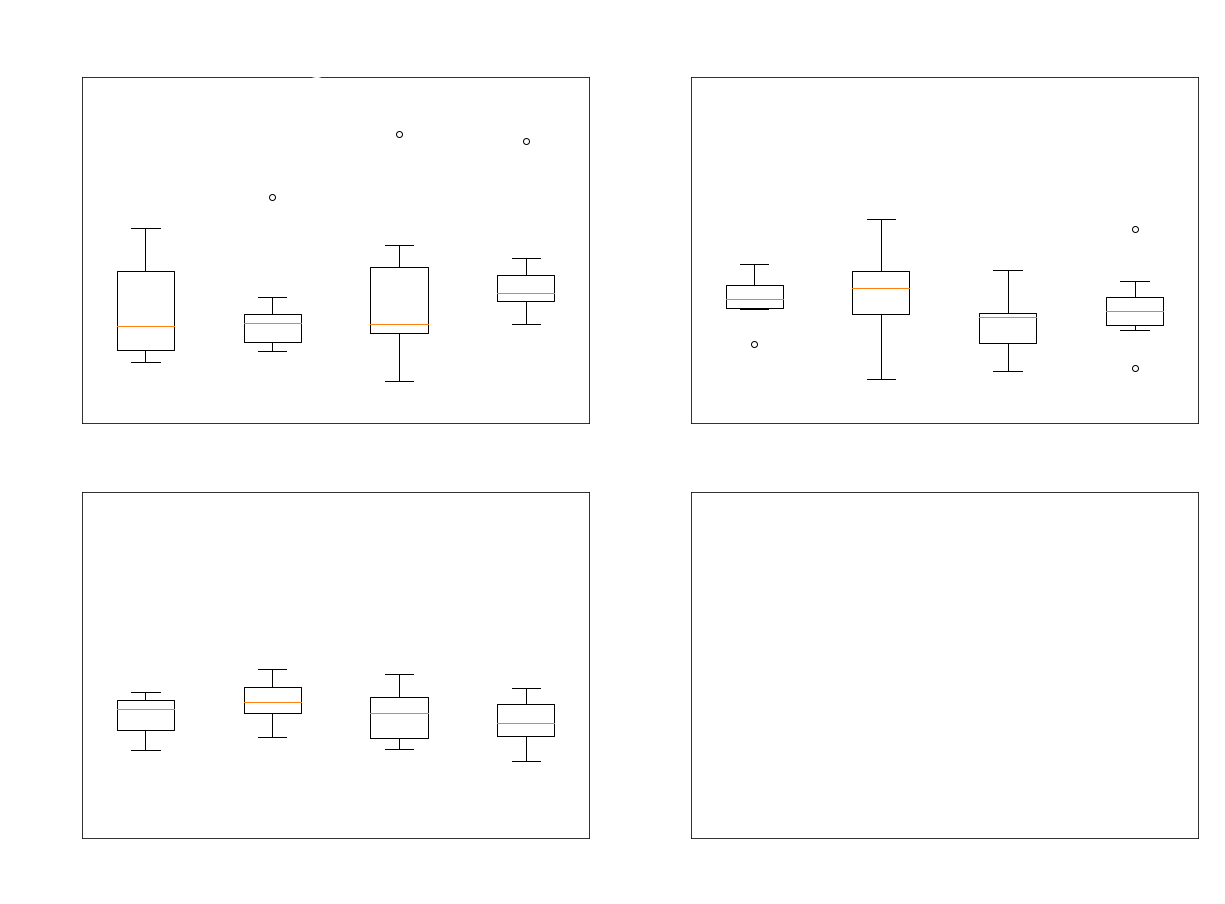

In [70]:
## 4-quadrant plot showing CV IKI distribution of IKI position in the string by Avg. BF (includes error, for all words not grouped)

figure, axs = plt.subplots(2, 2, figsize=(20, 14))
figure.suptitle('CV IKI Distribution by Avg. BF w/ error', y=0.95)

axs[0, 0].boxplot((typ.cv_all(typ.highbf, all_rts).loc[:, 1:4]))
axs[0, 0].set_title("High BF")
axs[0, 0].set_ylim([-0.01, 1.5])
axs[0, 1].boxplot((typ.cv_all(typ.medbf, all_rts).loc[:, 1:4]))
axs[0, 1].set_title("Med BF")
axs[0, 1].set_ylim([-0.01, 1.5])
axs[1, 0].boxplot((typ.cv_all(typ.lowbf, all_rts).loc[:, 1:4]))
axs[1, 0].set_title("Low BF")
axs[1, 0].set_ylim([-0.01, 1.5])

for ax in axs.flat:
    ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

## Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

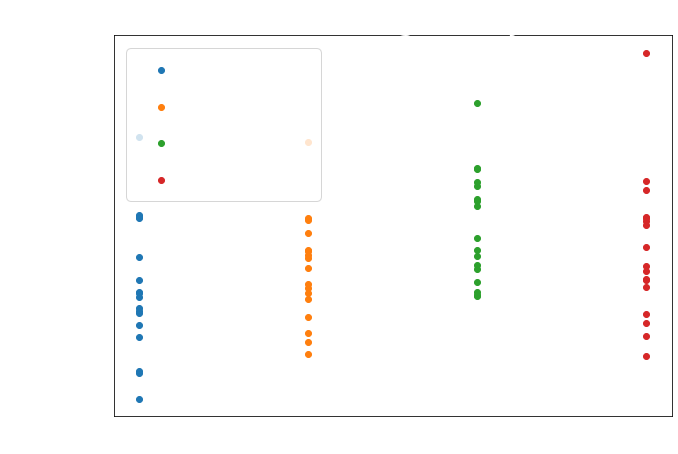

In [71]:
## Raster plot showing indiv. IKI averages by WF

plt.figure(figsize=(10, 7))
highwf_scatter = plt.scatter(([0] * len((avgiki_bysub(highwf_rts)).iloc[:, 1])), avgiki_bysub(highwf_rts).iloc[:, 1], label='High WF')
medwf_scatter = plt.scatter(([1] * len((avgiki_bysub(medwf_rts)).iloc[:, 1])), avgiki_bysub(medwf_rts).iloc[:, 1], label='Med WF')
lowwf_scatter = plt.scatter(([2] * len((avgiki_bysub(lowwf_rts)).iloc[:, 1])), avgiki_bysub(lowwf_rts).iloc[:, 1], label='Low WF')
pseudo_scatter = plt.scatter(([3] * len((avgiki_bysub(pseudo_rts)).iloc[:, 1])), avgiki_bysub(pseudo_rts).iloc[:, 1], label='Pseudo')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by WF")
plt.legend(loc= "best")

plt.show()

# WIP
___

In [72]:
## running wilcoxon rank-sum test between IKI and CV IKI
ranksums(indiv_means(tight_bgs, 'bigram', high_bgs['Bigrams'])['Avg IKI'], 
         indiv_avgcvs(tight_bgs, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'])

ranksums(indiv_means(all_bigrams, 'bigram', high_bgs['Bigrams'])['Avg IKI'],
         indiv_avgcvs(all_bigrams, 'bigram', high_bgs['Bigrams'])['Avg CV IKI'])

NameError: name 'ranksums' is not defined

In [ ]:
def delta_iki(bigram, string):
    all_deltas = []
    for sub in ID_list:
        sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
        deltas = [sub]
        for trial in range(0, len(sub_df) - 1):
            deltas.append(sub_df.loc[trial + 1, 'IKI'] - sub_df.loc[trial, 'IKI']) ## depends on column position
        all_deltas.append(deltas)
    all_deltas = pd.DataFrame(all_deltas)
    all_deltas = all_deltas.transpose()
    return all_deltas

In [ ]:
def iki_change_bysub(bigram, string):
    all_subs = pd.DataFrame()
    for sub in ID_list:
        sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
        ikis = sub_df['IKI'].tolist()
        while len(ikis) != 10:
            ikis.append(np.nan)
        all_subs[sub] = ikis
    return all_subs
        
iki_change_bysub('pu', 'puppy')

In [ ]:
##plotting IKI accross repetitions for each individual

df = iki_change_bysub('pu', 'puppy')

df.plot(figsize=(10, 7))

# plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
plt.xlabel("Repetition #")
plt.ylabel("IKI (s)")
# plt.ylim([0, 0.8])
plt.title("")
plt.legend().remove()

plt.show()

In [ ]:
## plotting average IKI for a particular bigram in a particular word across repetitions (for correct trials only)

plt.figure(figsize=(10, 7))
for bg in typ.lowbf_bgs:
    by_bg = corr_trials_bybg[corr_trials_bybg.bigram == bg]
    rep_ikis = []
    for n in range(0, 9):
        all_reps = by_bg[by_bg['rep #'] == n]
        avg_iki_byrep = all_reps['IKI'].mean()
        rep_ikis.append(avg_iki_byrep)

        plt.plot(rep_ikis)

        # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
        plt.xlabel("Repetition #")
        plt.ylabel("Avg IKI (s)")
        # plt.ylim([0, 0.8])
        plt.title("")
        # plt.legend().remove()

plt.show()

In [ ]:
yk_df = delta_iki('dk', 'vodka')[1:]

yk_df.plot(figsize=(10, 7))

# plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
plt.xlabel("Inter-repetition position")
plt.ylabel("Delta IKI (s)")
# plt.ylim([0, 0.8])
plt.title("")
plt.legend(loc="best")

plt.show()

In [ ]:
def indiv_means_bgonly(bigram):
    means = pd.DataFrame()
    DF = tight_bgs[tight_bgs['bigram'] == bigram]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        means = means.append({'ID':sID, 'bigram':bigram, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
    return means

def indiv_cvs_bgonly(bigram):
    cvs = pd.DataFrame()
    DF = tight_bgs[tight_bgs['bigram'] == bigram]
    for sID in ID_list:
        indiv = DF[DF['sID'] == sID]
        cvs = cvs.append({'ID':sID, 'bigram':bigram, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
    return cvs

In [ ]:
all_indiv_means = pd.DataFrame()
for bigram in bg_freqs['Bigrams']:
    all_indiv_means = all_indiv_means.append(indiv_means_bgonly(bigram), ignore_index=True).dropna(axis = 0)

all_indiv_cvs = pd.DataFrame()
for bigram in bg_freqs['Bigrams']:
    all_indiv_cvs = all_indiv_cvs.append(indiv_cvs_bgonly(bigram), ignore_index=True).dropna(axis = 0)

In [ ]:
## plot of individual avg iki values by bigram

fig, ax = plt.subplots(figsize=(50, 30))

for bigram in bg_freqs['Bigrams']:
    for sub in ID_list:
        bg_df = all_indiv_means[all_indiv_means.ID == sub]
    # bg_df = all_indiv_means[all_indiv_means.ID == 83]
        ax.plot(bg_df['bigram'], bg_df['Avg IKI'])

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("Avg Individual IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_df['bigram'])
# plt.legend(loc= "best")
plt.ylim([0, 0.4])
# plt.ylim([0.04775, 0.04825])

plt.show()

In [ ]:
## plot of individual cv iki values by bigram

fig, ax = plt.subplots(figsize=(50, 30))

for bigram in bg_freqs['Bigrams']:
    for sub in ID_list:
        bg_df = all_indiv_cvs[all_indiv_cvs.ID == sub]
    # bg_df = all_indiv_means[all_indiv_means.ID == 83]
        ax.plot(bg_df['bigram'], bg_df['CV IKI'])

plt.xlabel("Chosen Bigrams by Bigram Freq.")
plt.ylabel("Avg Individual IKI (s)")
plt.title("")
plt.xticks(np.arange(70), bg_df['bigram'])
# plt.legend(loc= "best")
plt.ylim([0, 1])
# plt.ylim([0.04775, 0.04825])

plt.show()

In [ ]:
indiv_means_bybg('there', 'th')

In [ ]:
th_means = pd.concat([indiv_means_bybg('there', 'th'), indiv_means_bybg('think', 'th'), indiv_means_bybg('theme', 'th'), indiv_means_bybg('therm', 'th')]
                     , ignore_index=True)
print(th_means)

# print(AnovaRM(data=th_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [ ]:
th_cvs = pd.concat([indiv_cvs('there', 'th'), indiv_cvs('think', 'th'), indiv_cvs('theme', 'th'), indiv_cvs('therm', 'th')]
                     , ignore_index=True)

print(AnovaRM(data=th_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [ ]:
th_position_means = pd.concat([indiv_means('therm', 'th'), indiv_means('tithe', 'th')], ignore_index=True)

print(AnovaRM(data=th_position_means, depvar='Avg IKI', subject='ID', within=['String']).fit()) 

In [ ]:
th_position_cvs = pd.concat([indiv_cvs('therm', 'th'), indiv_cvs('tithe', 'th')], ignore_index=True)

print(AnovaRM(data=th_position_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [ ]:
th_wf_means = pd.concat([indiv_means('tithe', 'th'), indiv_means('edthe', 'th')], ignore_index=True)

print(AnovaRM(data=th_wf_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [ ]:
th_wf_cvs = pd.concat([indiv_cvs('tithe', 'th'), indiv_cvs('edthe', 'th')], ignore_index=True)

print(AnovaRM(data=th_wf_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())